<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Standard Variational Autoencoders for Collaborative Filtering on MovieLens dataset. 
This notebook accompanies the paper "*A Hybrid Variational Autoencoder for Collaborative Filtering*" by Kilol Gupta, Mukund Y. Raghuprasad, Pankhuri Kumar [[Gupta et al.,2018]](https://arxiv.org/pdf/1808.01006.pdf). We will study a part of this paper, more specific, the derivation of the "*Standard Variational Autoencoder*" [[Gupta et al.,2018, chapter 5.1]](https://arxiv.org/pdf/1808.01006.pdf) . 

The "*Standard Variational Autoencoder*" is enhanced using $\mathbf \beta$-VAE [[Higgins et al, 2016]](https://openreview.net/pdf?id=Sy2fzU9gl), [[Burgess et al, 2018]](https://arxiv.org/pdf/1804.03599.pdf). Also, for tuning the parameter $\mathbf \beta$ an annealing methodology is used based on [[Bowman et al, 2015]](https://arxiv.org/pdf/1511.06349.pdf) and [[Liang, Dawen, et al,2018]](https://dl.acm.org/doi/pdf/10.1145/3178876.3186150?casa_token=Heh8W001edYAAAAA:P_y4buj0zb2ml8GpDXONkrc3EYEBOxgjZNAJOuqes60aeJ4C1Vg1Wq5Eh6mkCXhxNKp38pO_eUw).


In this notebook, we will show a complete self-contained example of training a "*Standard Variational Autoencoder*" with a simple ELBO function/loss (described in the original paper) and the prosposed extention of it. The public Movielens-1M dataset is used for training and evaluating our model. For this notebook it is assumed that the reader has basic knowledge about VAE [[Kingma et al, 2013]](https://arxiv.org/pdf/1312.6114.pdf). 





# 0 Global Settings and Imports

In [ ]:
# download the necessary libraries 
! pip install tensorflow==2.2.0-rc1
! pip install keras==2.3.1
! pip install papermill

In [8]:
import sys
sys.path.append("../../")
import os
import numpy as np
import pandas as pd
import papermill as pm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import tensorflow as tf
import keras

from reco_utils.common.timer import Timer
from reco_utils.dataset import movielens
from reco_utils.dataset.split_utils import min_rating_filter_pandas
from reco_utils.dataset.python_splitters import numpy_stratified_split
from reco_utils.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from reco_utils.common.constants import SEED as DEFAULT_SEED

from reco_utils.recommender.vae.sparse_vae_2 import AffinityMatrix, binarize_matrix
from reco_utils.recommender.vae.standard_vae import StandardVAE

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))
print("Keras version: {}".format(keras.__version__))

System version: 3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]
Pandas version: 1.1.2
Tensorflow version: 2.2.0-rc1
Keras version: 2.3.1


In [9]:
# top k items to recommend
TOP_K = 100

# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '1m'

# Model parameters
HELDOUT_USERS = 600 # CHANGE FOR DIFFERENT DATASIZE
INTERMEDIATE_DIM = 200
LATENT_DIM = 70
EPOCHS = 400
BATCH_SIZE = 100

# temporary Path to save the optimal model's weights
tmp_dir = TemporaryDirectory()
WEIGHTS_PATH = os.path.join(tmp_dir, "svae_weights.hdf5")

SEED = 98765


# 1 Standard-VAE algorithm


__Notations__: We use $u \in \{1,\dots,U\}$ to index users and $i \in \{1,\dots,I\}$ to index items. In this work, we consider learning with implicit feedback. The user-by-item interaction matrix is the click matrix $\mathbf{X} \in \mathbb{N}^{U\times I}$. The lower case $\mathbf{x}_u =[X_{u1},\dots,X_{uI}]^\top \in \mathbb{N}^I$ is a bag-of-words vector with the number of clicks for each item from user u. We binarize the click matrix. 

__Standard-VAE Model__: Autoencoder based recommendation is an unsupervised model attempting to reconstruct its input data in the output layer. The middle layer (bottleneck layer) is used as a salient feature representation of the input data. In this notebook, we study the standard variational autoencoder and derive the variational lower bound loss function of the standard variational autoencoder. The output of the SVAE is a probability distribution over the K items. This differs from the normal VAE that has the final output as the reconstructed input. So, the SVAE takes the user ratings in the form of a click matrix, $\mathbf{x}_u$, as inputs and then are encoded to learn the mean, $\mathbf{m}_u$, and the standard deviation, $\mathbf{σ}_u$, of the K-dimensional latent representation through the encoder function, $\mathbf{g}_φ(\mathbf{x}_u)$ = $\mathbf{m}_u$, $\mathbf{σ}_u$. In other words, the latent vector for each user,  $\mathbf{z}_u$, is sampled from the Gaussian distribution, where $\mathbf{z}_u$ ∼ N($\mathbf{m}_u$, $\mathbf{σ}_u$). Then, the decoder function, $\mathbf{f}_θ$($\mathbf{z}_u$) = $\mathbf{π}_u$, is used to decode the latent vector from K-dimensional space to a probability distribution $\mathbf{π}_u$ in the original N-dimensional space. As a result, we get the probabilities of each of the N movies being viewed by each user.

The objective __function/loss__ used in the model is the __ELBO__:

$$Loss= \log p_\theta(\mathbf{x}_u | \mathbf{z}_u) -  KL (q(\mathbf{z}_u)||p(\mathbf{z}_u|\mathbf{x}_u))$$

where:
* $\mathbf{x}_u$: the movie feature vector
* $\mathbf{z}_u$: latent representation of $\mathbf{x}_u$
* $KL$: The Kullback-Leibler divergence measure

The first part of the ELBO equation considers the logistic log-likelihood for a movie given its latent representation (reconstruction error), while the second KL term can be viewed as a regularization part. Our goal is to maximize __ELBO__, which is equivalent to minimizing the negative ELBO  (__NELBO__).

The logistic log-likelihood fuction is given as, $$\log p_\theta(\mathbf{x}_u | \mathbf{z}_u) = \sum_{i} \mathbf{x}_{ui} \log \mathbf{σ}(\mathbf{f}_{ui}) + (1 - \mathbf{x}_{ui}) \log(1 - \mathbf{σ}(\mathbf{f}_{ui})) $$

where: 
* $\mathbf{σ}(\mathbf{x}) = 1 / (1+ \exp(-\mathbf{x}))$ taken over all the movies i.

In addition, we extended the **ELBO** by introducing a parameter β  ([Higgins et al, 2016](https://openreview.net/pdf?id=Sy2fzU9gl), [Burgess et al, 2018](https://arxiv.org/pdf/1804.03599.pdf) ) to control the strength of regularization:

$$Loss= \log p_\theta(\mathbf{x}_u | \mathbf{z}_u) - \mathbf{β}  KL (q(\mathbf{z}_u)||p(\mathbf{z}_u|\mathbf{x}_u))$$



Τhe regularization view of the **ELBO** introduces a
trade-off between how well we can fit the data and how close the
approximate posterior stays to the prior during learning. By introducing the parameter $\mathbf{β}$ < 1, we are weakening the influence of the prior constraint. As a result, the model is less able to generate novel user histories by ancestral sampling. It is important to mention that our goal is not to maximize likelihood or generate imagined user histories, rather, our goal is to make good recommendations. So by treating $\mathbf{β}$ as a free regularization parameter yields significant improvements in performance. We propose two different experiments. 

At first, the training of the model is being done by setting $\mathbf{β}$=1 [[Gupta et al.,2018, chapter 5.1]](https://arxiv.org/pdf/1808.01006.pdf).


Finally, we introduce a simple heuristic for tuning $\mathbf{β}$. We anneal the KL divergence all the way to a specific value of $\mathbf{β}$, reaching that value at around 80% of the total number of epochs used during the training process. Then we identify the best performing  $\mathbf{β}$  based on the peak validation metric, and retrain the model with the same annealing schedule, but for the rest of epochs we are not increasing  $\mathbf{β}$  after reaching its optimal value.

It can be hard to imagine how to evaluate a recommender system. The primary concern of recommender systems is that they need to be able to put relevant items very high up the list of recommendations. So we need rank-aware metrics to select recommenders that aim at these two primary goals:
1.	Where does the recommender place the items it suggests?
2.	How good is the recommender at modeling relative preference?
 
So, the rank-aware metric we use is the Normalized Discounted Cumulative Gain. NDCG value putting highly relevant documents high up the recommended lists. It is able to use the fact that some documents are “more” relevant than others. It compares the predicted rank of the held-out items with their true rank. The metric recall, primarily concerned with being good at finding things. We need metrics that emphasis being good at finding and ranking things, like NDCG. That's why we emphasize in NDCG.





# 2 Keras implementation of Standard VAE

For the implementation of the model, Keras package is used. 

We will use the MovieLens dataset, which is composed of user-to-item interactions and integer ratings from 1 to 5. We convert MovieLens into binarized clicked matrix ( 1: the user liked this movie , 0: the user did NOT like or did NOT watch/rate this movie), and evaluate based on heldout users data.


# 3 Data Preparation

### 3.1 Load data and split

We load the data and create train / validation / test splits following strong generalization: 

- We split all unique users into training users and heldout users (i.e. validation and test users)

- By using the lists of these users, we obtain corresponding training data and heldout data, which are converted to click matrices

- We train models using the entire click history of the training users. 

- To evaluate, we take part of the click history from heldout (validation and test) data to learn the necessary user-level representations for the model and then compute metrics by looking at how well the model ranks the rest of the unseen click history from the heldout data

#### 3.1.1 Load data

In [10]:
df = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    header=["userID", "itemID", "rating", "timestamp"]
)

df.head()

100%|██████████| 5.78k/5.78k [00:00<00:00, 6.19kKB/s]


,userID,itemID,rating,timestamp
0,1,1193,5.0,978300760
1,1,661,3.0,978302109
2,1,914,3.0,978301968
3,1,3408,4.0,978300275
4,1,2355,5.0,978824291


In [11]:
df.shape

(1000209, 4)

#### 3.1.2 Data Filtering 



For the data filtering we are using the below 3 steps which are recommended by the original paper [[Liang, Dawen, et al,2018]](https://dl.acm.org/doi/pdf/10.1145/3178876.3186150?casa_token=zul5haircsAAAAAA:iIKn7y-xWwSeqaP-MmmyUaJoJuNZX9Fx1aXeFJwkwtMpVDCrPMW3kZjuYo1LKhSuMeUMNf1mbP2o).


We have to make sure that :
 - user-to-movie interactions with rating <=3.5 are filtered out. Applying this filtering we make sure that if a movie is rated less than 3.5 from the users that they watched this movie, it will not be contained in the final click matrix. If we fo not apply this filter, the final click matrix will be even sparser.
 - the users who clicked less than 5 movies are filtered out. 
 - the movies which are not clicked by any user are filtered out.


In [12]:
# Binarize the data (only keep ratings >= 4)
df_preferred = df[df['rating'] > 3.5]
print (df_preferred.shape)
df_low_rating = df[df['rating'] <= 3.5]


# df.head()
df_preferred.head(10)

(575281, 4)


,userID,itemID,rating,timestamp
0,1,1193,5.0,978300760
3,1,3408,4.0,978300275
4,1,2355,5.0,978824291
6,1,1287,5.0,978302039
7,1,2804,5.0,978300719
8,1,594,4.0,978302268
9,1,919,4.0,978301368
10,1,595,5.0,978824268
11,1,938,4.0,978301752
12,1,2398,4.0,978302281


In [13]:
df_low_rating

,userID,itemID,rating,timestamp
1,1,661,3.0,978302109
2,1,914,3.0,978301968
5,1,1197,3.0,978302268
16,1,2687,3.0,978824268
20,1,2321,3.0,978302205
...,...,...,...,...
1000195,6040,1079,2.0,956715648
1000197,6040,2020,3.0,956715288
1000198,6040,2021,3.0,956716374
1000203,6040,1090,3.0,956715518


In [14]:
# Keep users who clicked on at least 5 movies
df = min_rating_filter_pandas(df_preferred, min_rating=5, filter_by="user")

# Keep movies that were clicked on by at least on 1 user
df = min_rating_filter_pandas(df, min_rating=1, filter_by="item")

In [15]:
# Obtain both usercount and itemcount after filtering
usercount = df[['userID']].groupby('userID', as_index = False).size()
itemcount = df[['itemID']].groupby('itemID', as_index = False).size()

# Compute sparsity after filtering
sparsity = 1. * df.shape[0] / (usercount.shape[0] * itemcount.shape[0])

print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (df.shape[0], usercount.shape[0], itemcount.shape[0], sparsity * 100))

After filtering, there are 575272 watching events from 6034 users and 3533 movies (sparsity: 2.699%)


#### 3.1.3 Split data

For data slitting we use:
- 600 (~ 10%) users in validation set 
- 600 (~ 10%) users in testing set 
- the rest of them (~ 80%) in training set

Since the model is trained using the click history of the training users, we have to make sure that the movies that exist in the validation and test sets are the movies that exist in the train set. In other words, validation and test set should not contain movies that do not exist in the train set.

In [16]:
unique_users = sorted(df.userID.unique())
np.random.seed(SEED)
unique_users = np.random.permutation(unique_users)

In [17]:
# Create train/validation/test users
n_users = len(unique_users)
print("Number of unique users:", n_users)

train_users = unique_users[:(n_users - HELDOUT_USERS * 2)]
print("\nNumber of training users:", len(train_users))

val_users = unique_users[(n_users - HELDOUT_USERS * 2) : (n_users - HELDOUT_USERS)]
print("\nNumber of validation users:", len(val_users))

test_users = unique_users[(n_users - HELDOUT_USERS):]
print("\nNumber of test users:", len(test_users))

Number of unique users: 6034

Number of training users: 4834

Number of validation users: 600

Number of test users: 600


In [18]:
# For training set keep only users that are in train_users list
train_set = df.loc[df['userID'].isin(train_users)]
print("Number of training observations: ", train_set.shape[0])

# For validation set keep only users that are in val_users list
val_set = df.loc[df['userID'].isin(val_users)]
print("\nNumber of validation observations: ", val_set.shape[0])

# For test set keep only users that are in test_users list
test_set = df.loc[df['userID'].isin(test_users)]
print("\nNumber of test observations: ", test_set.shape[0])

# train_set/val_set/test_set contain user - movie interactions with rating 4 or 5

Number of training observations:  462827

Number of validation observations:  57388

Number of test observations:  55057


In [19]:
# Obtain list of unique movies used in training set
unique_train_items = pd.unique(train_set['itemID'])
print("Number of unique movies that rated in training set", unique_train_items.size)

Number of unique movies that rated in training set 3497


In [20]:
# For validation set keep only movies that used in training set
val_set = val_set.loc[val_set['itemID'].isin(unique_train_items)]
print("Number of validation observations after filtering: ", val_set.shape[0])

# For test set keep only movies that used in training set
test_set = test_set.loc[test_set['itemID'].isin(unique_train_items)]
print("\nNumber of test observations after filtering: ", test_set.shape[0])

Number of validation observations after filtering:  57374

Number of test observations after filtering:  55027


## 3.2 Click matrix generation 

From section 3.1 we end up with 3 datasets train_set, val_set and test_set.  For our model we need to give a click matrix as an input that contains only 0-s and 1-s, where each row represents a user and each column represents a movie. 
So, the click matrix contains the preferences of the user, marking each cell with 0 when the user did not enjoy (ratings below 3.5) or did not watch a movie and with 1 when the user enjoyed a movie (ratings above 3.5).

The training set will be a click matrix containing full historicity of all training users. However, the test set and validation set should be splitted into train and test parts. As a result, we get 4 datasets:
- val_data_tr
- val_data_te
- test_data_tr
- test_data_te


_'val_data_tr'_ contains 75% of the the preferred movies (movies marked as 1 in the click matrix) per user.
The rest 25% of the preffered movies are contained into the _'val_data_te'_. The same splitting is followed for test set. 

The _'val_data_tr'_ is given as an input for our model at the end of each epoch. The result of the model is a _'reconstructed_val_data_tr'_, which contains the movies recommended for each user by the model. In order to evaluate the performance of the model, at the end of each epoch, we compare the _'reconstructed_val_data_tr'_ (predicted recommendations by the model) with the _'val_data_te'_ (true movie preferences of each user) using NDCG@k metric. 

For the final evaluation of the model the _'test_data_tr'_ and _'test_data_te'_ are being used. As we described before, the _'test_data_tr'_ is given as an input for the model and returns the _'reconstructed_test_data_tr'_ dataset with the recommendations made by the model. Then, the _'reconstructed_test_data_tr'_ is compared with _'test_data_te'_ through different metrics:
- MAP
- NDCG@k
- Recall@k
- Precision@k






In [21]:
# Instantiate the sparse matrix generation for train, validation and test sets
# use list of unique items from training set for all sets
am_train = AffinityMatrix(DF=train_set, items_list=unique_train_items)

am_val = AffinityMatrix(DF=val_set, items_list=unique_train_items)

am_test = AffinityMatrix(DF=test_set, items_list=unique_train_items)

In [22]:
# Obtain the sparse matrix for train, validation and test sets
train_data,_,_ = am_train.gen_affinity_matrix()
print(train_data.shape)

val_data, val_map_users , val_map_items = am_val.gen_affinity_matrix()
print(val_data.shape)

test_data,test_map_users , test_map_items = am_test.gen_affinity_matrix()
print(test_data.shape)

(4834, 3497)
(600, 3497)
(600, 3497)


In [23]:
# Split validation and test data into training and testing parts
val_data_tr, val_data_te = numpy_stratified_split(val_data, ratio=0.75, seed=SEED)
test_data_tr, test_data_te = numpy_stratified_split(test_data, ratio=0.75, seed=SEED)

In [24]:
# Binarize train, validation and test data
train_data = binarize_matrix(data=train_data, threshold=3.5)
val_data = binarize_matrix(data=val_data, threshold=3.5)
test_data = binarize_matrix(data=test_data, threshold=3.5)

In [25]:
# Binarize validation data: training part  
val_data_tr = binarize_matrix(data=val_data_tr, threshold=3.5)

# Binarize validation data: testing part (save non-binary version in the separate object, will be used for calculating NDCG)
val_data_te_ratings = val_data_te.copy()
val_data_te = binarize_matrix(data=val_data_te, threshold=3.5)

In [26]:
# Binarize test data: training part 
test_data_tr = binarize_matrix(data=test_data_tr, threshold=3.5)

# Binarize test data: testing part (save non-binary version in the separate object, will be used for calculating NDCG)
test_data_te_ratings = test_data_te.copy()
test_data_te = binarize_matrix(data=test_data_te, threshold=3.5)

In [27]:
# retrieve real ratings from initial dataset 

test_data_te_ratings=pd.DataFrame(test_data_te_ratings)
val_data_te_ratings=pd.DataFrame(val_data_te_ratings)

for index,i in df_low_rating.iterrows():
  user_old= i['userID'] # old value 
  item_old=i['itemID'] # old value 

  if (test_map_users.get(user_old) is not None)  and (test_map_items.get(item_old) is not None) :
      user_new=test_map_users.get(user_old) # new value 
      item_new=test_map_items.get(item_old) # new value 
      rating=i['rating'] 
      test_data_te_ratings.at[user_new,item_new]= rating   

  if (val_map_users.get(user_old) is not None)  and (val_map_items.get(item_old) is not None) :
      user_new=val_map_users.get(user_old) # new value 
      item_new=val_map_items.get(item_old) # new value 
      rating=i['rating'] 
      val_data_te_ratings.at[user_new,item_new]= rating   


val_data_te_ratings=val_data_te_ratings.to_numpy()    
test_data_te_ratings=test_data_te_ratings.to_numpy()    
# test_data_te_ratings  

In [28]:
# Just checking
print(np.sum(val_data))
print(np.sum(val_data_tr))
print(np.sum(val_data_te))

57374.0
43028.0
14346.0


In [29]:
# Just checking
print(np.sum(test_data))
print(np.sum(test_data_tr))
print(np.sum(test_data_te))

55027.0
41278.0
13749.0


# 4 Train Standard-VAE using Keras


__Model Architecture:__

For "MovieLens-1M dataset", we set both the generative function and the inference model to be 3-layer multilayer perceptron (MLP) with symmetrical architecture.
The generative function is a [70 -> 200 -> n_items] MLP, which means the inference function is a [n_items -> 200 -> 70] MLP. Thus the overall architecture for the Multi-VAE is [n_items -> 200 -> 70 -> 200 -> n_items]. 

Also, Dropout is applied both in encoder and decoder to avoid overfitting. 

Note that this architecture, illustrated in the graph below, is the one that resulted optimal results after doing hyperparameter tuning.



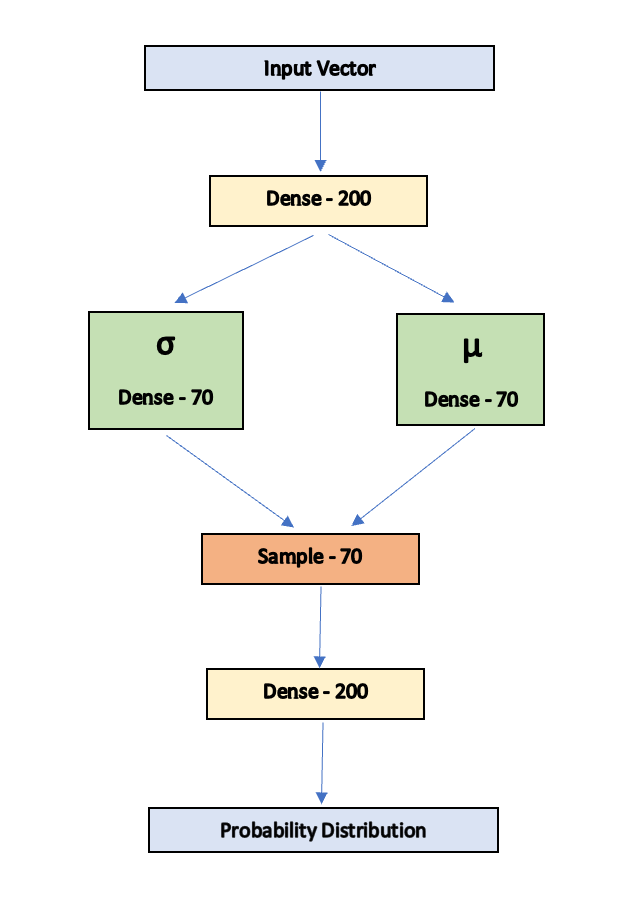

## 4.1 Standard VAE without annealing  (initial approach)

Firstly, we train Standard-VAE model using constant $\mathbf \beta$= 1.



In [30]:
model_without_anneal = StandardVAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                   original_dim=train_data.shape[1], # Number of unique items in the training set
                                   intermediate_dim=INTERMEDIATE_DIM, 
                                   latent_dim=LATENT_DIM, 
                                   n_epochs=EPOCHS, 
                                   batch_size=BATCH_SIZE, 
                                   k=TOP_K,
                                   verbose=0,
                                   seed=SEED,
                                   save_path=WEIGHTS_PATH,
                                   drop_encoder=0.5,
                                   drop_decoder=0.5,
                                   annealing=False,
                                   beta=1.0
                                   )

In [31]:
with Timer() as t:
    model_without_anneal.fit(x_train=train_data, 
                             x_valid=val_data, 
                             x_val_tr=val_data_tr, 
                             x_val_te=val_data_te_ratings, # with the original ratings 
                             mapper=am_val
                             )
print("Took {} seconds for training.".format(t))

Took 635.6573 seconds for training.


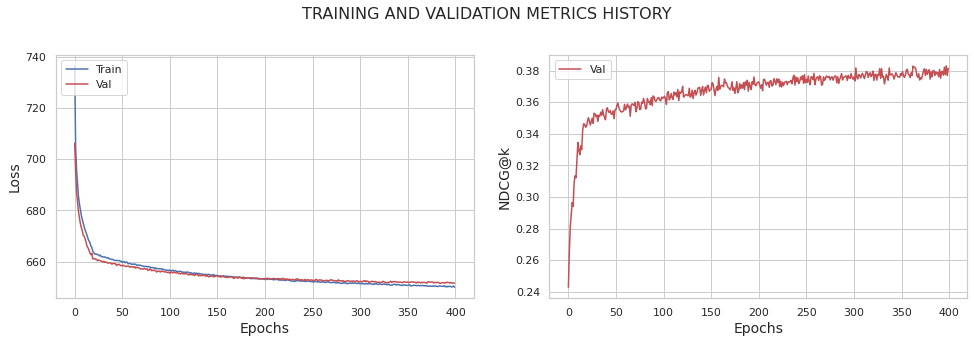

In [ ]:
model_without_anneal.display_metrics() 

In [33]:
ndcg_val_without_anneal = model_without_anneal.ndcg_per_epoch()

#### Prediction and Evaluation of Standard-VAE model using constant 𝛽 = 1.

Evaluate with recommending 10 items.

In [ ]:
# Use k = 10
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_without_anneal.recommend_k_items(x=test_data_tr,
                                                    k=10,
                                                    remove_seen=True
                                                    )

    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_1 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_ndcg_1 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_precision_1 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_recall_1 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=10)

print("MAP@10:\t\t%f" % eval_map_1,
      "NDCG@10:\t%f" % eval_ndcg_1,
      "Precision@10:\t%f" % eval_precision_1,
      "Recall@10: \t%f" % eval_recall_1, sep='\n')

Took 0.9969 seconds for prediction.
MAP@10:		0.051831
NDCG@10:	0.446227
Precision@10:	0.421667
Recall@10: 	0.081252


Evaluate with recommending 100 items.

In [ ]:
# Use k = TOP_K 
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_without_anneal.recommend_k_items(x=test_data_tr,
                                                    k=TOP_K,
                                                    remove_seen=True
                                                    )

    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_2 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)
eval_ndcg_2 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)
eval_precision_2 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)
eval_recall_2 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)

print("MAP@100:\t%f" % eval_map_2,
      "NDCG@100:\t%f" % eval_ndcg_2,
      "Precision@100:\t%f" % eval_precision_2,
      "Recall@100: \t%f" % eval_recall_2, sep='\n')

Took 0.4622 seconds for prediction.
MAP@100:	0.138111
NDCG@100:	0.392379
Precision@100:	0.231383
Recall@100: 	0.354346


## 4.2 Standard VAE with annealing 
We are going to use annealing procedure for finding the optimal $\mathbf \beta$.

Now, in order to find the optimal β, we train our model using annealing with anneal_cap equal 1.0.






In [36]:
model_with_anneal = StandardVAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                original_dim=train_data.shape[1], # Number of unique items in the training set
                                intermediate_dim=INTERMEDIATE_DIM, 
                                latent_dim=LATENT_DIM, 
                                n_epochs=EPOCHS, 
                                batch_size=BATCH_SIZE, 
                                k=TOP_K,
                                verbose=0,
                                seed=SEED,
                                save_path=WEIGHTS_PATH,
                                drop_encoder=0.5,
                                drop_decoder=0.5,
                                annealing=True,
                                anneal_cap=1.0
                                )

In [37]:
with Timer() as t:
    model_with_anneal.fit(x_train=train_data, 
                          x_valid=val_data, 
                          x_val_tr=val_data_tr, 
                          x_val_te=val_data_te_ratings, #  with the original ratings
                          mapper=am_val
                          )
print("Took {} seconds for training.".format(t))

Took 633.1969 seconds for training.


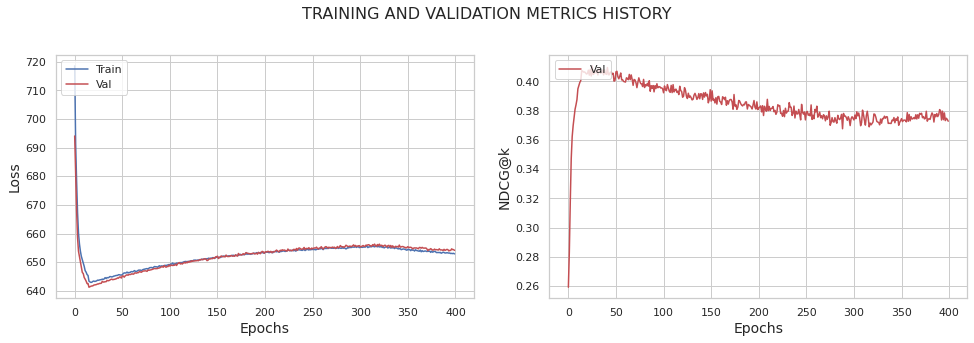

In [38]:
model_with_anneal.display_metrics()

In [42]:
ndcg_val_with_anneal = model_with_anneal.ndcg_per_epoch()

Using the optimal beta as anneal cap , we retrain our model. 

When NDCG@k of validation set reach a peak, the weights of the model are saved. Using this model we evaluate the test set. 

In [40]:
# Get optimal beta 
optimal_beta = model_with_anneal.get_optimal_beta()
print( "The optimal beta is: ", optimal_beta)

The optimal beta is:  0.08125


In [44]:
model_optimal_beta = StandardVAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                 original_dim=train_data.shape[1], # Number of unique items in the training set
                                 intermediate_dim=INTERMEDIATE_DIM,
                                 latent_dim=LATENT_DIM,
                                 n_epochs=EPOCHS,
                                 batch_size=BATCH_SIZE,
                                 k=TOP_K,  
                                 verbose=0,
                                 seed=SEED,
                                 save_path=WEIGHTS_PATH,
                                 drop_encoder=0.5,
                                 drop_decoder=0.5,
                                 annealing=True,
                                 anneal_cap=optimal_beta,  
                                 )

In [45]:
with Timer() as t:
    model_optimal_beta.fit(x_train=train_data, 
                           x_valid=val_data, 
                           x_val_tr=val_data_tr, 
                           x_val_te=val_data_te_ratings, # with the original ratings
                           mapper=am_val
                           )
print("Took {} seconds for training.".format(t))

Took 639.4168 seconds for training.


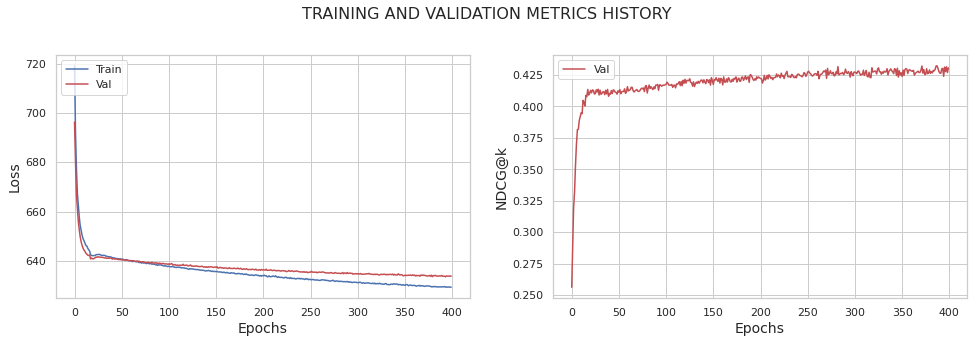

In [ ]:
 model_optimal_beta.display_metrics()

In [47]:
ndcg_val_optimal_beta = model_optimal_beta.ndcg_per_epoch()

#### Prediction and Evaluation of Standard-VAE model using the optimal 𝛽 with annealing.

Evaluate with recommending 10 items.

In [ ]:
# Use k = 10
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_optimal_beta.recommend_k_items(x=test_data_tr,
                                                  k=10,
                                                  remove_seen=True
                                                  )

    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_3 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_ndcg_3 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_precision_3 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_recall_3 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=10)

print("MAP@10:\t\t%f" % eval_map_3,
      "NDCG@10:\t%f" % eval_ndcg_3,
      "Precision@10:\t%f" % eval_precision_3,
      "Recall@10: \t%f" % eval_recall_3, sep='\n')

Took 0.1775 seconds for prediction.
MAP@10:		0.066183
NDCG@10:	0.496464
Precision@10:	0.473000
Recall@10: 	0.101120


Evaluate with recommending 10 items.

In [ ]:
# Use k = TOP_K
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_optimal_beta.recommend_k_items(x=test_data_tr,
                                                  k=TOP_K,
                                                  remove_seen=True
                                                  )

    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_4 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)
eval_ndcg_4 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)
eval_precision_4 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)
eval_recall_4 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)

print("MAP@100:\t%f" % eval_map_4,
      "NDCG@100:\t%f" % eval_ndcg_4,
      "Precision@100:\t%f" % eval_precision_4,
      "Recall@100: \t%f" % eval_recall_4, sep='\n')

Took 0.4522 seconds for prediction.
MAP@100:	0.171624
NDCG@100:	0.443328
Precision@100:	0.251867
Recall@100: 	0.409650


# 5 Conclusion 

Through this notebook, it is proven that the VAE using annealing outperforms the model without annealing (using $\mathbf \beta$=1). Specifically, the results of evaluting the test set, for the the 2 different approaches, are:

| Model | NDCG@100  |NDCG@10 | 
| --- | --- | --- | 
| Standard-VAE (wihtout annealing, β=1)| 0.392 | 0.446 |
| Standard-VAE (with annealing, optimal β)| 0.443 | 0.496 | 


This annealing procedure is used as an efficient way to tune the parameter $\mathbf \beta$. Otherwise, training multiple models using different values of $\mathbf \beta$ can be really time consuming. 

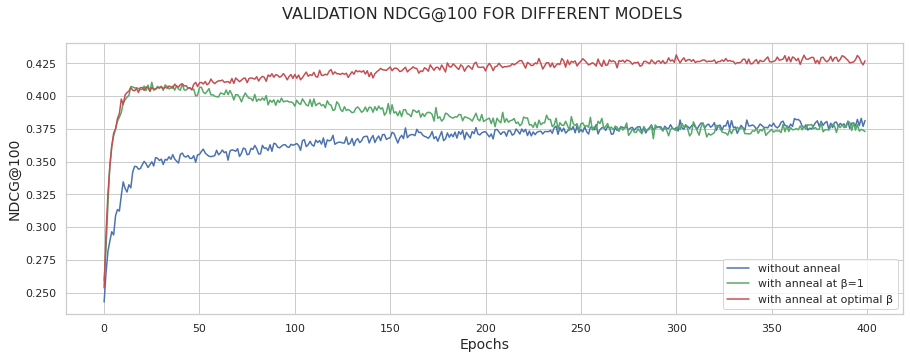

In [ ]:
# Plot setup
plt.figure(figsize=(15, 5))
sns.set(style='whitegrid')

# Plot NDCG@k of validation sets for three models
plt.plot(ndcg_val_without_anneal, color='b', linestyle='-', label='without anneal')
plt.plot(ndcg_val_with_anneal, color='g', linestyle='-', label='with anneal at β=1')
plt.plot(ndcg_val_optimal_beta, color='r', linestyle='-', label='with anneal at optimal β')

# Add plot title and axis names
plt.title('VALIDATION NDCG@100 FOR DIFFERENT MODELS \n', size=16)
plt.xlabel('Epochs', size=14)
plt.ylabel('NDCG@100', size=14)
plt.legend(loc='lower right')

plt.show()


# 6 References

[Liang, Dawen, et al, 2018] [Liang, Dawen, et al. "Variational autoencoders for collaborative filtering." Proceedings of the 2018 World Wide Web Conference. 2018.](https://dl.acm.org/doi/pdf/10.1145/3178876.3186150?casa_token=zul5haircsAAAAAA:iIKn7y-xWwSeqaP-MmmyUaJoJuNZX9Fx1aXeFJwkwtMpVDCrPMW3kZjuYo1LKhSuMeUMNf1mbP2o) 

[Kingma et al, 2013] [Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes."  (2013).](https://arxiv.org/pdf/1312.6114.pdf)

[Burgess et al, 2018] [Burgess, Christopher P., et al. "Understanding disentangling in $\beta $-VAE." (2018)](https://arxiv.org/pdf/1804.03599.pdf)

[Higgins et al, 2016] [Higgins, Irina, et al. "beta-vae: Learning basic visual concepts with a constrained variational framework." (2016).](https://openreview.net/pdf?id=Sy2fzU9gl)


[Bowman et al, 2015] [Samuel R. Bowman, Luke Vilnis, Oriol Vinyals, Andrew M. Dai, Rafal Jozefowicz,
and Samy Bengio. 2015. Generating sentences from a continuous space. (2015).](https://arxiv.org/pdf/1511.06349.pdf)
